In [216]:
import torch
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import pandas as pd
import node_kernel

class WarpGBM(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        num_bins=10,
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        min_child_weight=20,
        min_split_gain=0.0,
        verbosity=True
    ):
        self.num_bins = num_bins
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.forest = None
        self.bin_edges = None  # shape: [num_features, num_bins-1] if using quantile binning
        self.base_prediction = None
        self.unique_eras = None
        self.device = "cuda"
        self.root_gradient_histogram = None
        self.root_hessian_histogram = None
        self.gradients = None
        self.root_node_indices = None
        self.bin_indices = None
        self.Y_gpu = None
        self.num_features = None
        self.num_samples = None
        self.out_feature = torch.zeros(1, device=self.device, dtype=torch.int32)
        self.out_bin = torch.zeros(1, device=self.device, dtype=torch.int32)
        self.min_child_weight = min_child_weight
        self.min_split_gain = min_split_gain

    def fit(self, X, y, era_id):
        self.bin_indices, era_indices, self.bin_edges, self.unique_eras, self.Y_gpu = self.preprocess_gpu_data(X, y, era_id)
        self.num_samples, self.num_features = X.shape
        self.gradients = torch.zeros_like(self.Y_gpu)
        self.root_node_indices = torch.arange(self.num_samples, device=self.device)
        self.base_prediction = self.Y_gpu.mean().item()
        self.gradients += self.base_prediction
        self.split_gains = torch.zeros((self.num_features, self.num_bins - 1), device=self.device)
        self.forest = self.grow_forest()
        return self

    def compute_quantile_bins(self, X, num_bins):
        quantiles = torch.linspace(0, 1, num_bins + 1)[1:-1]  # exclude 0% and 100%
        bin_edges = torch.quantile(X, quantiles, dim=0)       # shape: [B-1, F]
        return bin_edges.T  # shape: [F, B-1]
    
    def preprocess_gpu_data(self, X_np, Y_np, era_id_np):
        self.num_samples, self.num_features = X_np.shape
        Y_gpu = torch.from_numpy(Y_np).type(torch.float32).to(self.device)
        era_id_gpu = torch.from_numpy(era_id_np).type(torch.int32).to(self.device)
        is_integer_type = np.issubdtype(X_np.dtype, np.integer)
        if is_integer_type:
            max_vals = X_np.max(axis=0)
            if np.all(max_vals < self.num_bins):
                print("Detected pre-binned integer input — skipping quantile binning.")
                bin_indices = torch.from_numpy(X_np).to(self.device).contiguous().to(torch.int8)
    
                # We'll store None or an empty tensor in self.bin_edges
                # to indicate that we skip binning at predict-time
                bin_edges = torch.arange(1, self.num_bins, dtype=torch.float32).repeat(self.num_features, 1)
                bin_edges = bin_edges.to(self.device)
                unique_eras, era_indices = torch.unique(era_id_gpu, return_inverse=True)
                return bin_indices, era_indices, bin_edges, unique_eras, Y_gpu
            else:
                print("Integer input detected, but values exceed num_bins — falling back to quantile binning.")
    
        print("Performing quantile binning on CPU...")
        X_cpu = torch.from_numpy(X_np).type(torch.float32)  # CPU tensor
        bin_edges_cpu = self.compute_quantile_bins(X_cpu, self.num_bins).type(torch.float32).contiguous()
        bin_indices_cpu = torch.empty((self.num_samples, self.num_features), dtype=torch.int8)
        for f in range(self.num_features):
            bin_indices_cpu[:, f] = torch.bucketize(X_cpu[:, f], bin_edges_cpu[f], right=False).type(torch.int8)
        bin_indices = bin_indices_cpu.to(self.device).contiguous()
        bin_edges = bin_edges_cpu.to(self.device)
        unique_eras, era_indices = torch.unique(era_id_gpu, return_inverse=True)
        return bin_indices, era_indices, bin_edges, unique_eras, Y_gpu

    def compute_histograms(self, bin_indices_sub, gradients):
        grad_hist = torch.zeros((self.num_features, self.num_bins), device=self.device, dtype=torch.float32)
        hess_hist = torch.zeros((self.num_features, self.num_bins), device=self.device, dtype=torch.float32)
    
        node_kernel.compute_histogram(
            bin_indices_sub,
            gradients,
            grad_hist,
            hess_hist,
            self.num_bins
        )
        return grad_hist, hess_hist

    def find_best_split(self, gradient_histogram, hessian_histogram):
        node_kernel.compute_split(
            gradient_histogram.contiguous(),
            hessian_histogram.contiguous(),
            self.num_features,
            self.num_bins,
            0.0,  # L2 reg
            1.0,  # L1 reg
            1e-6, # hess cap
            self.out_feature,
            self.out_bin
        )
        
        f = int(self.out_feature[0])
        b = int(self.out_bin[0])
        return (f, b)
    
    def grow_tree(self, gradient_histogram, hessian_histogram, node_indices, depth):
        if depth == self.max_depth:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            return {"leaf_value": leaf_value.item(), "samples": node_indices.numel()}
    
        parent_size = node_indices.numel()
        best_feature, best_bin = self.find_best_split(gradient_histogram, hessian_histogram)
    
        if best_feature == -1:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            return {"leaf_value": leaf_value.item(), "samples": parent_size}
    
        split_mask = (self.bin_indices[node_indices, best_feature] <= best_bin)
        left_indices = node_indices[split_mask]
        right_indices = node_indices[~split_mask]

        left_size = left_indices.numel()
        right_size = right_indices.numel()

        if left_size == 0 or right_size == 0:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            return {"leaf_value": leaf_value.item(), "samples": parent_size}

        if left_size <= right_size:
            grad_hist_left, hess_hist_left = self.compute_histograms(
                self.bin_indices[left_indices],
                self.residual[left_indices]
            )
            grad_hist_right = gradient_histogram - grad_hist_left
            hess_hist_right = hessian_histogram - hess_hist_left
        else:
            grad_hist_right, hess_hist_right = self.compute_histograms(
                self.bin_indices[right_indices],
                self.residual[right_indices]
            )
            grad_hist_left = gradient_histogram - grad_hist_right
            hess_hist_left = hessian_histogram - hess_hist_right

        new_depth = depth + 1
        left_child = self.grow_tree(grad_hist_left, hess_hist_left, left_indices, new_depth)
        right_child = self.grow_tree(grad_hist_right, hess_hist_right, right_indices, new_depth)
    
        return { "feature": best_feature, "bin": best_bin, "left": left_child, "right": right_child }

    def grow_forest(self):
        forest = [{} for _ in range(self.n_estimators)]
        self.training_loss = []
    
        for i in range(self.n_estimators):
            self.residual = self.Y_gpu - self.gradients
    
            self.root_gradient_histogram, self.root_hessian_histogram = \
                self.compute_histograms(self.bin_indices, self.residual)
    
            tree = self.grow_tree(
                self.root_gradient_histogram,
                self.root_hessian_histogram,
                self.root_node_indices,
                depth=0
            )
            forest[i] = tree
            loss = ((self.Y_gpu - self.gradients) ** 2).mean().item()
            self.training_loss.append(loss)
            print(f"🌲 Tree {i+1}/{self.n_estimators} - MSE: {loss:.6f}")
    
        print("Finished training forest.")
        return forest

    def predict(self, X_np, era_id_np=None):
        is_integer_type = np.issubdtype(X_np.dtype, np.integer)
        if is_integer_type:
            max_vals = X_np.max(axis=0)
            if np.all(max_vals < self.num_bins):
                bin_indices = X_np.astype(np.int8)
                return self.predict_data(bin_indices)

        X_cpu = torch.from_numpy(X_np).type(torch.float32)  # CPU tensor
        bin_indices_cpu = torch.empty((X_np.shape[0], X_np.shape[1]), dtype=torch.int8)
        bin_edges_cpu = self.bin_edges.to('cpu')
        for f in range(self.num_features):
            bin_indices_cpu[:, f] = torch.bucketize(X_cpu[:, f], bin_edges_cpu[f], right=False).type(torch.int8)

        bin_indices = bin_indices_cpu.numpy()  # Use CPU numpy array for predict_data
        return self.predict_data(bin_indices)

    def process_node(self, node, data_idx, bin_indices):
        if 'leaf_value' in node:
            return node['leaf_value']
        else:
            if bin_indices[data_idx, node['feature']] <= node['bin']:
                return self.process_node(node['left'], data_idx, bin_indices)
            else:
                return self.process_node(node['right'], data_idx, bin_indices)

    def predict_data(self, bin_indices):
        n = bin_indices.shape[0]
        preds = np.zeros(n)
        for i in range(n):
            preds[i] = self.base_prediction + self.learning_rate * np.sum([
                self.process_node(tree_node, i, bin_indices) for tree_node in self.forest
            ])
        return preds


In [229]:
'''
Datasets:

1) Test 2D Dataset with visualization
2) Test High Dimensional Data Set
3) Numerai Data

'''


#1


# # Generate a simple 2D dataset
num_samples = 1000  # Keep it small for clarity

# Generate X in a fun spiral-ish pattern plus some noise
r = np.linspace(0.5, 2.5, num_samples)
theta = np.linspace(0, 4 * np.pi, num_samples)
X1 = r * np.cos(theta) + np.random.normal(0, 0.2, num_samples)
X2 = r * np.sin(theta) + np.random.normal(0, 0.2, num_samples)
X_np = np.stack([X1, X2], axis=1)

# Create a more interesting non-linear target
Y_np = (X_np[:, 0]**2 - X_np[:, 1]**2) + 0.5 * X_np[:, 0]
eras = np.zeros(num_samples)


#2

# def generate_spiral_dataset(num_samples=1_000_000, num_features=10, noise_std=0.2, seed=42):
#     np.random.seed(seed)

#     # Spiral base in 2D
#     r = np.linspace(0.5, 2.5, num_samples)
#     theta = np.linspace(0, 4 * np.pi, num_samples)
#     X1 = r * np.cos(theta) + np.random.normal(0, noise_std, num_samples)
#     X2 = r * np.sin(theta) + np.random.normal(0, noise_std, num_samples)
    
#     # Initial 2D spiral features
#     X = [X1, X2]
    
#     # Create additional synthetic features (some linear, some non-linear)
#     for i in range(2, num_features):
#         if i % 2 == 0:
#             X_i = np.sin(X1) * np.cos(X2) + np.random.normal(0, noise_std, num_samples)
#         else:
#             X_i = X1 * X2 + np.random.normal(0, noise_std, num_samples)
#         X.append(X_i)
    
#     X_np = np.stack(X, axis=1)

#     # Non-linear target function based on first few features
#     Y_np = (X1**2 - X2**2) + 0.5 * X1 + 0.3 * X_np[:, 2] - 0.2 * X_np[:, 3]

#     # Dummy eras
#     eras = np.zeros(num_samples, dtype=int)

#     return X_np, Y_np, eras

# X_np, Y_np, eras = generate_spiral_dataset(num_samples=1_000_000, num_features=10)

#3)

DATA_VERSION = "v5.0"
train = pd.read_parquet(f"../SignalMiner/{DATA_VERSION}/train.parquet")

s = 100_000 # num_samples
n = 100 # num_features

feature_set = [ f for f in list(train) if 'feat' in f ][:n]
targets = [ t for t in list(train) if 'target' in t ]

X_np = train[feature_set].astype('int8').values[:s]
Y_np = train[targets[0]].values[:s]
eras = np.zeros(len(Y_np))
f"{len(feature_set) * len(X_np):,}"

'10,000,000'

In [238]:
max_depth = 7
num_bins = 5
n_estimators = 100
learning_rate = 1
era_model = WarpGBM(
    max_depth = max_depth,
    num_bins = num_bins,
    n_estimators = n_estimators,
    learning_rate = learning_rate,
    verbosity=False
)

# era_model.load_data( X_np, Y_np, eras)

In [239]:
import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
# era_model.init_data()
# era_model.grow_forest()
era_model.fit(X_np, Y_np, eras)

profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(20)  # Show top 20 functions


Detected pre-binned integer input — skipping quantile binning.
🌲 Tree 1/100 - MSE: 0.048347
🌲 Tree 2/100 - MSE: 0.047042
🌲 Tree 3/100 - MSE: 0.045886
🌲 Tree 4/100 - MSE: 0.044895
🌲 Tree 5/100 - MSE: 0.043988
🌲 Tree 6/100 - MSE: 0.043090
🌲 Tree 7/100 - MSE: 0.042194
🌲 Tree 8/100 - MSE: 0.041412
🌲 Tree 9/100 - MSE: 0.040630
🌲 Tree 10/100 - MSE: 0.039847
🌲 Tree 11/100 - MSE: 0.039114
🌲 Tree 12/100 - MSE: 0.038517
🌲 Tree 13/100 - MSE: 0.037961
🌲 Tree 14/100 - MSE: 0.037372
🌲 Tree 15/100 - MSE: 0.036705
🌲 Tree 16/100 - MSE: 0.036089
🌲 Tree 17/100 - MSE: 0.035515
🌲 Tree 18/100 - MSE: 0.034951
🌲 Tree 19/100 - MSE: 0.034402
🌲 Tree 20/100 - MSE: 0.033898
🌲 Tree 21/100 - MSE: 0.033429
🌲 Tree 22/100 - MSE: 0.032946
🌲 Tree 23/100 - MSE: 0.032490
🌲 Tree 24/100 - MSE: 0.032053
🌲 Tree 25/100 - MSE: 0.031644
🌲 Tree 26/100 - MSE: 0.031231
🌲 Tree 27/100 - MSE: 0.030835
🌲 Tree 28/100 - MSE: 0.030451
🌲 Tree 29/100 - MSE: 0.030066
🌲 Tree 30/100 - MSE: 0.029699
🌲 Tree 31/100 - MSE: 0.029362
🌲 Tree 32/100 - 

In [ ]:
import time
tic = time.time()
preds_era = era_model.predict(X_np[:100000])
toc = time.time()
np.corrcoef([preds_era, Y_np[:100000]]), "predict time: ", toc - tic, " seconds"

In [241]:
era_model.gradients[0], preds_era[0]

(tensor(0.4063, device='cuda:0'), 0.40628288864172646)

In [242]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
    max_depth = max_depth, 
    n_estimators=n_estimators, 
    verbose=1, 
    max_bins=num_bins, 
    learning_rate=learning_rate, 
    num_leaves=2**max_depth,
)

In [243]:

import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
model.fit(
    X_np,
    Y_np,
    eval_set=[(X_np, Y_np)],         # in-sample loss
    eval_names=["train"],
    eval_metric="l2",                      # or "rmse", "l1"
    callbacks=[lgb.log_evaluation(1)]                      # 👈 prints eval results each round
)
profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(20)  # Show top 20 functions


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 99
[LightGBM] [Info] Start training from score 0.500112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's l2: 0.0483713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's l2: 0.0470521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's l2: 0.0459382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train's l2: 0.0447906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's l2: 0.0438093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	train's l2

In [244]:
preds_lgbm = model.predict(X_np[:1000])
np.corrcoef([preds_lgbm, Y_np[:1000]])

array([[1.        , 0.81538093],
       [0.81538093, 1.        ]])

In [245]:
np.corrcoef([preds_lgbm, preds_era])

array([[1.        , 0.82516956],
       [0.82516956, 1.        ]])

In [140]:
print("Warp base:", era_model.base_prediction)
print("LGBM base:", model.booster_.predict(X_np[:1], pred_leaf=False, raw_score=True)[0])


Warp base: 0.013152649626135826
LGBM base: 0.06022670500050299


In [98]:

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     # Run the slow function
#     forest = grow_forest(num_trees, root_node_indices, bin_indices, Y_gpu, gradients, num_bins, max_depth, lr)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))



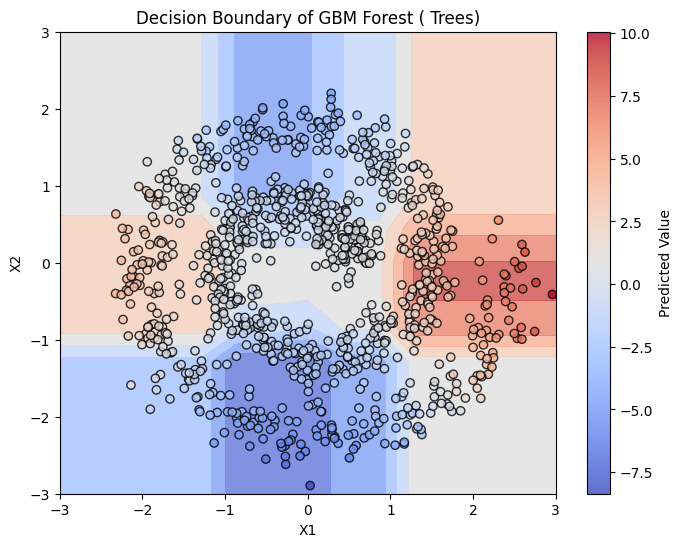

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size and range
grid_size = 15
x1_range = np.linspace(-3, 3, grid_size)
x2_range = np.linspace(-3, 3, grid_size)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid_np = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])  # Flatten for batch prediction
Z_grid = era_model.predict(X_grid_np)
plt.figure(figsize=(8, 6))
plt.contourf(X1_grid, X2_grid, Z_grid.reshape(grid_size,grid_size), cmap="coolwarm", alpha=0.7)
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, cmap="coolwarm", edgecolor="k", marker="o", alpha=0.8)
plt.colorbar(label="Predicted Value")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Decision Boundary of GBM Forest ( Trees)")
plt.show()


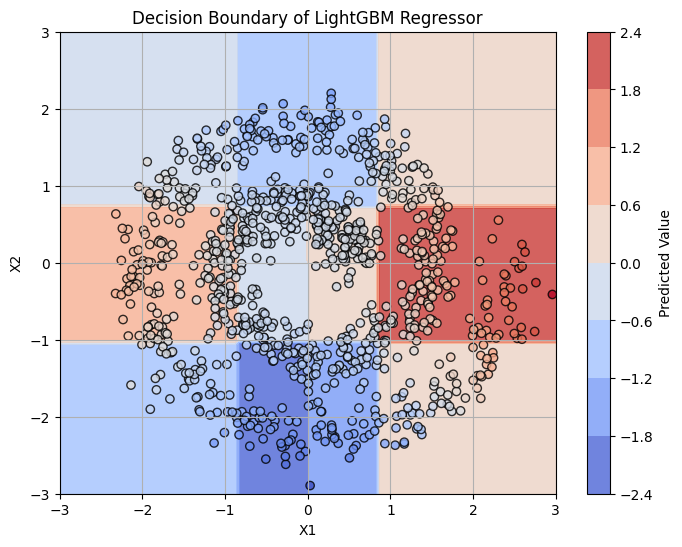

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a grid of values over the same domain as your training data
grid_size = 100
x1 = np.linspace(-3, 3, grid_size)
x2 = np.linspace(-3, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]  # shape: (grid_size**2, 2)

# Use LightGBM model to predict on the grid
Z = model.predict(X_grid)
Z = Z.reshape(X1.shape)

# Plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Z, cmap='coolwarm', alpha=0.8)
plt.colorbar(contour, label="Predicted Value")
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, edgecolor="k", cmap="coolwarm", alpha=0.8)
plt.title("Decision Boundary of LightGBM Regressor")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()


In [32]:
'''pytorch profiler'''

# import torch.profiler

# with torch.profiler.profile(
#     activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
#     record_shapes=True,
#     profile_memory=True,
#     with_stack=True
# ) as prof:
#     era_model.fit(X_np, Y_np, eras)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))


'pytorch profiler'